In [189]:
import pandas as pd
import numpy as np
import glob
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from datetime import datetime as dt
import unidecode
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.multiclass import OneVsRestClassifier
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import string
import cv2


import re
import pickle

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve, f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.colors import Normalize

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.sparse import hstack
from scipy.special import logit, expit

# from my_nmf import NMF
# from helpers import build_text_vectorizer, hand_label_topics, analyze_article

plt.style.use('seaborn')
# os.chdir("data")

ModuleNotFoundError: No module named 'cv2'

In [2]:
file = 'data/comments.csv'
df = pd.read_csv(file, names = ['Text', 'ID', 'Subreddit', 'meta', 'Time', 'Username', 'Upvotes', 'Downvotes', 'Author_link_karma', 'Author_Comment_Karma','Author_has_gold?'], parse_dates =True, encoding = 'utf-8')


In [486]:
df2['meta'].unique()

array(['news', 'lifestyle', 'learning', 'humor', 'entertainment',
       'television', 'gaming'], dtype=object)

In [516]:
df = df.dropna(axis =0)

# make meta dataframes

In [479]:
df_entertainment = df.dropna(axis =0).loc[df['meta']== 'entertainment']
# df_entertainment.Text
df

In [488]:
df_news = df.dropna(axis =0).loc[df['meta']== 'news']


In [624]:
df_lifestyle = df.dropna(axis =0).loc[df['meta']== 'lifestyle']


In [489]:
df_learning = df.dropna(axis =0).loc[df['meta']== 'learning']


In [490]:
df_humor = df.dropna(axis =0).loc[df['meta']== 'humor']
df_humor.shape

In [491]:
df_television = df.dropna(axis =0).loc[df['meta']== 'television']
df_television.shape

In [492]:
df_gaming = df.dropna(axis =0).loc[df['meta']== 'gaming']
df_gaming.shape

# Proper Pipeline, no alaska

In [494]:
df_news

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaimer : i think obama should nominate som...,d028c5d,politics,news,1.455651e+09,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way the process will be dragged out unt...,d026od6,politics,news,1.455648e+09,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republicans have always battled with severe ca...,d026wk3,politics,news,1.455649e+09,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,politics were so different back then. people o...,d02a3k3,politics,news,1.455653e+09,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,"equally ridiculous , here 's a 1970 law review...",d025wad,politics,news,1.455647e+09,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
414225,""" it 's like a wife seeing her husband with an...",d01xfh2,conspiracy,news,1.455635e+09,EveryPixelMatters,3.0,0.0,7516.0,13268.0,0.0
414226,everyone should do this ...go linux,d01vx2f,conspiracy,news,1.455632e+09,Romek_himself,5.0,0.0,12685.0,11383.0,0.0
414227,migrated myself a few months ago. already too ...,d01y642,conspiracy,news,1.455636e+09,ranter23209,2.0,0.0,274.0,66.0,0.0
414228,given the amount of phoning home w10 does...ye...,d02bojy,conspiracy,news,1.455655e+09,_josepi_,1.0,0.0,2.0,21792.0,0.0


In [160]:
def clean_urls(array):
    lst = []
    for string in array:
#         remove url strings
        if string > re.sub(r'(https|http)? : \/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE):
            string = re.sub(r'(https|http)? : \/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE)
#           remove extra youtube v's
            string = re.sub(r'v = () ', '', string, flags = re.MULTILINE)
            lst.append(string)
        else: 
            string = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE)
            lst.append(string)
    return lst
# test
# tokelems = clean_urls(df_entertainment.Text.values)
# cleaned_urls
# type(cleaned_urls[1])

In [665]:
punctuations = '''.!=-()[]{};:"|\<>/?@#$%^&*_~'''
replace = '{}'.format('\n')
lst = []

test_strings = ['James ran ForWard from the https://  !!! $ %   youtube.com v asfhabjf v asvjdakbfakdfasdfbasdfadfsasfadga %666^^ 32$']
test_strings2 = df_entertainment.Text.values[:2]
# print(test_strings2)

def base_clean_up(strings):
    new_strings = [] 
    for i in strings:
#         lower the strings
        i = i.lower()
#         convert strings to unicode
        i = unidecode.unidecode(i)
#         remove extra spaces
        i = re.sub(" +", " ", i)
        no_punct = ""
        for word in i.split():
#             remove any individual letters or extra spaces
            word = re.sub(r'[^\w\s]','',word)
            
            if len(word) > 20:
                word = ""
            no_punct += f'{word} '
        new_strings.append(no_punct)
#         print(no_punct)
    return new_strings



# # test check
clean_test = base_clean_up(test_strings)
print(clean_test)
# check using df
# tokelems = base_clean_up(tokelems)  
# base_clean_up1
# clean_test

['james ran forward from the https    youtubecom v asfhabjf v  666 32 ']


In [640]:
s_stop = set(stopwords.words())
print(len(s_stop))
new_stops = ['politics', 'libertarian', 'worldnews', 'offbeat', 'news',
       'truereddit', 'conspiracy', 'conservative', 'frugal',
       'motorcycles', 'sex', 'drunk', 'food', 'lifehacks', 'guns',
       'progresspics', 'askscience', 'science', 'explainlikeimfive',
       'askhistorians', 'youshouldknow', 'todayilearned', 'space',
       'circlejerk', 'facepalm', 'jokes', 'adviceanimals', 'funny',
       'imgoingtohellforthis', 'movies', 'harrypotter', 'music', 'anime',
       'comicbooks', 'starwars', 'doctorwho', 'community', 'breakingbad',
       'thewalkingdead', 'startrek', 'mylittlepony', 'gameofthrones',
       'himym', 'tf2', 'dota2', 'leagueoflegends', 'minecraft', 'pokemon',
       'gaming', 'skyrim', 'starcraft','nt','like', 'really', '2015ref',
        'publisherspage190ref','volume9', 'issue2','005', '1671', '2015', 
        'jpgthumbemerg', 'jpgthumbrightth', 'logo', 'page7','logo.png','2015.ref', 
        'nameleaf200kcit','ref', '005.jpgthumbrightth', 'whose', 'kind','png', 'jpg', 
        'wiktionaryzero', 'wiktionaryzero0', 'wiktionaryzero0', 'articlesquantum','0supsup', 
        '0refcit', '1-3', 'redirectzero', '.', ',', 'nameleaf200k2cit', 'wiktionari', 'namecarb01cit','-',
        'filezero', 'mvaramvarxmvari', 'page98','datemfyes1915228', 'year1989ref', '1671.jpgthumbemerg', 
        'refimprovedatemay','ligatureligatur','amazing', 'awesome', 'bad', 'best', 'better', 'bit', 
        'character', 'cool', 'day', 'end', 'episode', 'feel', 'film', 'going', 'good', 'great', 'know', 
        'life', 'little', 'll', 'looks', 'love', 'make', 'man', 'music', 'new', 'people', 'pretty', 'read', 
        'right', 'saw', 'scene', 'seen', 'sure', 'think', 'thought', 'want', 'wars', 'way', 'come', 'jpg','10',
        '11','12', 'amp', 'days', 'edit', 'far', 'gets', 'fun', 'getting','let', 'later', 'makes', 'men', 'na',
        'oh', 'op', 'post', 'reddit', 'said', 'remember', 'sorry', 'start', 'started', 'stop', 'tell', 'stuff',
        'took', 'try','use', 'used', 'wait', 'wanted', 'week','went', 'yeah', 'yes', 'work', 'world', 
        'pppc1expiry2144', 'wiktionary','wiktionary0', 'n','improvedateoctob','baiknya', 
        'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'अक', 'अग', 'अझ', 'अन', 'अर', 'आजक', 'आत', 'आद', 'आफ', 'आय', 'ईक', 'उद', 'उनक', 'उनल', 'उह', 'एउट', 'एन', 'कog', 'कत', 'कम', 'कस', 'कसर', 'कह', 'गत', 'गय', 'गर', 'चम', 'छन', 'जत', 'जबक', 'जस', 'जसक', 'जसब', 'जसम', 'जसल', 'जह', 'तत', 'तथ', 'तदन', 'तप', 'तवम', 'नज', 'नत', 'नभन', 'नय', 'पक', 'पछ', 'पन', 'पय', 'पर', 'पष', 'पह', 'बन', 'बर', 'भएक', 'भय', 'भव', 'मल', 'यत', 'यथ', 'यद', 'यप', 'यसक', 'यसपछ', 'यसब', 'यसर', 'यह', 'रण', 'रत', 'रमश', 'रह', 'लस', 'वर', 'सक', 'सट', 'सध', 'सपछ', 'सब', 'सम', 'सर', 'सह', 'हन', 'हर', 'हरण', 'ἀλλ']
for i in new_stops:
    s_stop.add(i)
    
print(len(s_stop))

6255
6595


In [163]:
def tokenizer(strings):
        lst = []
        for i in strings:
            tokens = [word for word in i.split(" ") if word not in s_stop]
            lst.append(tokens)
        return lst

# # test tokenizer 
tokelems = tokenizer(tokelems)
# print(test_tokes)
#     lst.append(no_punct)
# df_entertainment.Text = lst

In [164]:
def lemmatization(tokens):
#     for i in tokens:
    
    lems = [[lemmatizer.lemmatize(word) for word in sent] for sent in tokens]
    return lems
tokelems = lemmatization(tokelems)


# Pipeline

In [495]:
def piped(arr):
    arr = clean_urls(arr)
    arr = base_clean_up(arr)
    tokens = tokenizer(arr)
    lems = lemmatization(tokens)
    lst_final = []
    for i in lems:
        i = " ".join(i)
        lst_final.append(i)
    return lst_final

# add 'tokelems' to individual dataframes

In [532]:
# df['tokelems'] = piped(df.Text.values)

In [657]:
df_news['tokelems'] = piped(df_news.Text.values)

In [658]:
df_humor['tokelems'] = piped(df_humor.Text.values)

In [659]:
df_lifestyle['tokelems'] = piped(df_lifestyle.Text.values)

In [660]:
df_television['tokelems'] = piped(df_television.Text.values)

In [661]:
df_entertainment['tokelems'] = piped(df_entertainment.Text.values)

In [662]:
df_gaming['tokelems'] = piped(df_gaming.Text.values)

In [663]:
df_learning['tokelems'] = piped(df_learning.Text.values)

### create samples if you want to test on smaller data set quickly

In [ ]:
df_lifestyle_samp = df_lifestyle.sample(n=100000)
df_tele_samp = df_television.sample(n=100000)
df_gaming_samp = df_gaming.sample(100000)
df_entertainment_samp = df_entertainment.sample(n=100000)
df_humor_samp = df_humor.sample(n=100000)
df_news_samp = df_news.sample(n=100000)
df_learning_samp = df_learning.sample(n=100000)

# Concat the sample data frames. if it has a good score keep it

This is the overall meta predictor, will be step one of our decision tree


In [539]:
sample_df = pd.concat([df_humor_samp,df_tele_samp, df_news_samp, df_entertainment_samp, df_lifestyle_samp, df_gaming_samp, df_tele_samp])

In [541]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.965, min_df=.015, stop_words=new_stops)

In [542]:
vec_X = tfidf_vectorizer.fit_transform(sample_df['tokelems']).toarray()
y = sample_df['meta']

In [545]:
rfc_meta = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta.fit(vec_X, y)
rfc_meta.oob_score_

0.6481614285714286

In [547]:
#above needs work


# RFC meta


In [499]:
def RFC_meta_pipe(df):
    X = tfidf_vectorizer.fit_transform(df['Tokelems']).toarray()
    y = df['meta']
    rfc_df =RandomForestClassifier(n_estimators=20, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
    rfc_subs.fit(X, y)
    return rfc_subs.oob_score_
    

Instantiate vectorizer

In [408]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.965, min_df=.015, stop_words=new_stops)


### Entertainment

In [ ]:
vec_X = tfidf_vectorizer.fit_transform(df_entertainment['Tokelems']).toarray()

In [410]:
X = vec_X
y = df_entertainment['Subreddit']

In [429]:
rfc_subs =RandomForestClassifier(n_estimators=20, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_subs.fit(X, y)
rfc_subs.oob_score_ 

/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.7773602630342884

rfc_subs =RandomForestClassifier(n_estimators=20, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_subs.fit(X, y)
rfc_subs.oob_score_ = 0.7773602630342884


In [478]:
param_grid = { 
#     'n_estimators': [30,40,50, 60],
#     'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5,10,20,30, None],
    'min_samples_leaf':[1,2,3,4,5],
#     'min_impurity_decrease' :[10**-7, 10**-6, 10**-5, 0],
#     'max_leaf_nodes' : [10,100,None]
}
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5)
CV_rfc.fit(X, y)
print(CV_rfc.best_params_)

KeyboardInterrupt: 

In [166]:
dummiezed = pd.get_dummies(df_entertainment,columns = ['Subreddit'])
dummiezed


,Text,ID,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?,Tokelems,Subreddit_anime,Subreddit_comicbooks,Subreddit_harrypotter,Subreddit_movies,Subreddit_music,Subreddit_starwars
1446458,i can not wait to see him whoop some intergala...,d02nuw8,entertainment,1.455673e+09,cmonster1697,1.0,0.0,488.0,8426.0,0.0,"[wait, see, whoop, intergalactic, alien, butt,...",0,0,0,1,0,0
1446459,amazing cinematographer. one of the best to ev...,d02q51i,entertainment,1.455676e+09,BrodoFagginsIsMyName,1.0,0.0,1.0,457.0,0.0,"[amazing, cinematographer, best, ever, , ]",0,0,0,1,0,0
1446463,you 've finally had your life changed .,d02uuym,entertainment,1.455684e+09,BrodoFagginsIsMyName,3.0,0.0,1.0,457.0,0.0,"[finally, life, changed, , ]",0,0,0,1,0,0
1446464,that is awesome ! thanks !,d02ftgc,entertainment,1.455661e+09,JeopardyThis,3.0,0.0,1.0,-7.0,0.0,"[awesome, , thanks, , ]",0,0,0,1,0,0
1446465,"that tom cruise 's character , john anderton ,...",465qz3,entertainment,1.455672e+09,tangowhiskey33,16.0,0.0,7346.0,6138.0,0.0,"[tom, cruise, character, , john, anderton, , k...",0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1826308,i love it ! ! !,d026lj4,entertainment,1.455648e+09,elbowsss,2.0,0.0,2212.0,8637.0,1.0,"[love, , , , ]",0,0,1,0,0,0
1826309,you are the type of ra i hope i can be if i ma...,d02qfaf,entertainment,1.455677e+09,DEP61,2.0,0.0,5581.0,13488.0,0.0,"[type, ra, hope, manage, get, selected, , curr...",0,0,1,0,0,0
1826310,this was my bulletin board for the month too :...,d02rem2,entertainment,1.455678e+09,laneebird,2.0,0.0,43.0,8.0,0.0,"[bulletin, board, month, , p, ]",0,0,1,0,0,0
1826311,that 's so excellent ! i would be so pleased t...,d02ecuj,entertainment,1.455659e+09,GoodniteMush,1.0,0.0,1.0,681.0,0.0,"[excellent, , would, pleased, find, first, day...",0,0,1,0,0,0


# RFC Subreddits

0. datacleaning
1. dummyize the subs for target
2. vectorizer.fit_transform(data.tokelems)
3. sparse array.toarray()
4. X is now my obs by terms matrix i get, y is dummied target
5. rfc time

In [168]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.965, min_df=.015, stop_words=new_stops)

In [399]:
# new variable name, rerun to test
vec_X_full = tfidf_vectorizer.fit_transform(dummiezed['Tokelems']).toarray()

In [401]:
vec_X_full.shape


(357672, 160)

In [331]:
X = vec_X_full
y = dummiezed['Subreddit_anime']

In [333]:
print(len(X),len(y))

357672 357672


# Gaming


In [580]:
df_gaming = pd.get_dummies(df_gaming,columns = ['Subreddit'])
df_gaming.columns

Index(['Text', 'ID', 'meta', 'Time', 'Username', 'Upvotes', 'Downvotes',
       'Author_link_karma', 'Author_Comment_Karma', 'Author_has_gold?',
       'tokelems', 'Subreddit_dota2', 'Subreddit_gaming',
       'Subreddit_leagueoflegends', 'Subreddit_minecraft', 'Subreddit_pokemon',
       'Subreddit_skyrim', 'Subreddit_starcraft', 'Subreddit_tf2'],
      dtype='object')

In [649]:
X_gam = tfidf_vectorizer.fit_transform(df_gaming['tokelems']).toarray()
feats_games = tfidf_vectorizer.get_feature_names()

In [583]:
y_gaming = df_gaming['Subreddit_gaming']
rfc_gaming =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_gaming.fit(X_gam, y_gaming)
rfc_gaming.oob_score_

0.9126809285053804

In [668]:
sorted(list(zip(rfc_gaming.feature_importances_, feats_games)))

[(0.0030477303248849425, 'long'),
 (0.003229319975401607, 'help'),
 (0.0036613009900978667, 'change'),
 (0.003997701209269755, 'server'),
 (0.003998034484215726, 'maybe'),
 (0.00418145492911668, 'keep'),
 (0.004318438048682684, 'bug'),
 (0.004574559771695742, 'win'),
 (0.004789502067348661, 'top'),
 (0.004863082518074635, 'lol'),
 (0.005078044651461599, 'probably'),
 (0.0051057123283961905, 'give'),
 (0.005107790971851991, 'anyone'),
 (0.005190166529667892, 'dota'),
 (0.00535069552456216, 'map'),
 (0.005614184780087992, 'league'),
 (0.005685924702791785, 'post'),
 (0.005798953597023245, 'video'),
 (0.005869576899139477, 'another'),
 (0.00588922392503201, 'point'),
 (0.005900241150335956, 'gt'),
 (0.005947300136431082, 'start'),
 (0.006079880512522502, 'pokemon'),
 (0.006149375254076602, 'work'),
 (0.006227279939664999, 'try'),
 (0.006536969591246083, 'fun'),
 (0.006553039036135595, 'mean'),
 (0.006564594429056071, 'though'),
 (0.006740930393189457, 'two'),
 (0.0067642562431824635, 'har

In [584]:
y_dota = df_gaming['Subreddit_dota2']
rfc_dota =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_dota.fit(X_gam, y_dota)
rfc_dota.oob_score_

0.8904758571654872

In [669]:
sorted(list(zip(rfc_dota.feature_importances_, feats_games)))

[(0.003968976037071119, 'point'),
 (0.0041342149374272484, 'probably'),
 (0.004255482681907278, 'put'),
 (0.004287909053272725, 'two'),
 (0.004604035881189152, 'server'),
 (0.00480282441370439, 'long'),
 (0.004804177889769904, 'change'),
 (0.004906374018407639, 'keep'),
 (0.005007310144174009, 'video'),
 (0.00508096472592105, 'top'),
 (0.005259627743183707, 'help'),
 (0.005269648365741159, 'another'),
 (0.005289728483934134, 'cool'),
 (0.005418156070751183, 'friend'),
 (0.005500043165108426, 'thought'),
 (0.0057413680463175385, 'hit'),
 (0.0057635751647789665, 'let'),
 (0.0058293506881054126, 'around'),
 (0.005876388075388056, 'many'),
 (0.005951291081878834, 'use'),
 (0.006024141307845323, 'find'),
 (0.006180423984057254, 'fun'),
 (0.006195296284821138, 'edit'),
 (0.006273622343931759, 'start'),
 (0.0063096768007105, 'anyone'),
 (0.006317476565127781, 'map'),
 (0.0064499501685032126, 'since'),
 (0.006675277858756231, 'ever'),
 (0.006696283503559553, 'getting'),
 (0.006697364231079222,

In [592]:
y_lol = df_gaming['Subreddit_leagueoflegends']
rfc_lol =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_lol.fit(X_gam, y_lol)
rfc_lol.oob_score_

0.8628222083869043

In [670]:
sorted(list(zip(rfc_lol.feature_importances_, feats_games)))

[(0.0033993081140249156, 'hard'),
 (0.004238434916252271, 'two'),
 (0.0046378332371410326, 'keep'),
 (0.004745845106620003, 'level'),
 (0.00488170804638199, 'long'),
 (0.005099436454469277, 'point'),
 (0.005106942364034264, 'another'),
 (0.005192752406990571, 'put'),
 (0.005228289809941511, 'dota'),
 (0.005271521318249533, 'anyone'),
 (0.005372525033968266, 'though'),
 (0.005392884164400184, 'help'),
 (0.005404851441618073, 'start'),
 (0.005486341807979363, 'use'),
 (0.005645584681449295, 'sure'),
 (0.0056553103931764725, 'around'),
 (0.005660830870550771, 'getting'),
 (0.005728746107738119, 'fun'),
 (0.00577531271743922, 'find'),
 (0.006177087843000089, 'made'),
 (0.006235601772282834, 'cool'),
 (0.006353290684977657, 'win'),
 (0.00640679594808882, 'give'),
 (0.006451760961834505, 'new'),
 (0.006478128744866023, 'ever'),
 (0.0065848297262769565, 'many'),
 (0.0066540667079954445, 'try'),
 (0.00672972601472286, 'gt'),
 (0.006736899641559277, 'fuck'),
 (0.0067603825241233035, 'edit'),
 (

In [586]:
y_mine = df_gaming['Subreddit_minecraft']
rfc_mine =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_mine.fit(X_gam, y_mine)
rfc_mine.oob_score_

0.972160311220975

In [671]:
sorted(list(zip(rfc_mine.feature_importances_, feats_games)))

[(0.0006544265540521712, 'dota'),
 (0.0008018687226122144, 'fucking'),
 (0.0008420915828550273, 'win'),
 (0.0009798071527594029, 'league'),
 (0.001114433710005299, 'friend'),
 (0.0012827479637061016, 'pokemon'),
 (0.001916706993406743, 'two'),
 (0.002026832029469051, 'hard'),
 (0.0027952540665881222, 'fuck'),
 (0.0029548217869085867, 'played'),
 (0.0035579193766386453, 'shit'),
 (0.0037503960464668838, 'top'),
 (0.003843871810574297, 'hit'),
 (0.003961250373186998, 'playing'),
 (0.004413756007854872, 'team'),
 (0.004577405397373623, 'fun'),
 (0.005028577951355779, 'lol'),
 (0.005048714580927589, 'day'),
 (0.005218085258464099, 'level'),
 (0.005234842956297542, 'video'),
 (0.0052889030799507086, 'bad'),
 (0.005362051306761349, 'ever'),
 (0.005392045149561598, 'year'),
 (0.0055038365785086375, 'start'),
 (0.005555443902271309, 'let'),
 (0.005588547009378445, 'every'),
 (0.005671011501429351, 'help'),
 (0.005774010288241864, 'last'),
 (0.005812381955707309, 'point'),
 (0.00639175035048649

In [587]:
y_poke = df_gaming['Subreddit_pokemon']
rfc_poke =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_poke.fit(X_gam, y_poke)
rfc_poke.oob_score_

0.9411855721374707

In [672]:
sorted(list(zip(rfc_poke.feature_importances_, feats_games)))

[(0.00146733257710819, 'win'),
 (0.0018784000430773784, 'lol'),
 (0.0019245348596947697, 'server'),
 (0.0022092654290664327, 'dota'),
 (0.0024280066081123954, 'fuck'),
 (0.0024517217015764797, 'bug'),
 (0.002481747909391817, 'level'),
 (0.0024850859704874046, 'long'),
 (0.0027106406245356474, 'league'),
 (0.0028268431887078205, 'top'),
 (0.0031071083560188246, 'let'),
 (0.003180056784358856, 'last'),
 (0.003232634455250819, 'start'),
 (0.0033418124198466505, 'map'),
 (0.003592907505846946, 'hit'),
 (0.0036289730349519417, 'mean'),
 (0.003735452180792926, 'put'),
 (0.003760084200051474, 'change'),
 (0.003918400555865926, 'many'),
 (0.0040402675674348736, 'video'),
 (0.004323811014051263, 'lot'),
 (0.004506317840418355, 'bad'),
 (0.004518772047058964, 'help'),
 (0.004536488899224304, 'right'),
 (0.004563748349277385, 'probably'),
 (0.004625361175361207, 'friend'),
 (0.004666674841309241, 'though'),
 (0.004693484073124732, 'fucking'),
 (0.0047649810693376005, 'player'),
 (0.00485952086707

In [588]:
y_skyrim = df_gaming['Subreddit_skyrim']
rfc_skyrim =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_skyrim.fit(X_gam, y_skyrim)
rfc_skyrim.oob_score_

0.968660548836421

In [673]:
sorted(list(zip(rfc_skyrim.feature_importances_, feats_games)))

[(0.000966449496372496, 'win'),
 (0.0011807039024968613, 'dota'),
 (0.0012478963497350927, 'server'),
 (0.0016159234183309274, 'league'),
 (0.0016497468438622855, 'bug'),
 (0.0016731725757292081, 'bad'),
 (0.001678497788370046, 'pokemon'),
 (0.002164081685815579, 'lol'),
 (0.002790000640325783, 'fuck'),
 (0.002826255679712008, 'hit'),
 (0.0030050207077660226, 'nice'),
 (0.003331375396334279, 'map'),
 (0.003720888726265724, 'friend'),
 (0.0038407353712508283, 'point'),
 (0.0038423582644878974, 'team'),
 (0.003937388220667785, 'mean'),
 (0.004155425094185763, 'video'),
 (0.004824160706939412, 'player'),
 (0.004933440631610918, 'put'),
 (0.004938609782373807, 'hard'),
 (0.00521652543324407, 'fucking'),
 (0.00562526012956607, 'made'),
 (0.00570377557010098, 'since'),
 (0.005862837298089081, 'two'),
 (0.005867770681896557, 'day'),
 (0.005903996579895251, 'change'),
 (0.006062890380821722, 'let'),
 (0.006176989963606803, 'edit'),
 (0.006467468374107512, 'last'),
 (0.006579922544630816, 'cool

In [589]:
y_starcraft = df_gaming['Subreddit_starcraft']
rfc_starcraft =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_starcraft.fit(X_gam, y_starcraft)
rfc_starcraft.oob_score_

0.956223498509838

In [674]:
sorted(list(zip(rfc_starcraft.feature_importances_, feats_games)))

[(0.0019484756602602307, 'bug'),
 (0.0022139508404889594, 'pokemon'),
 (0.0025172438745109725, 'dota'),
 (0.003052003404011341, 'hit'),
 (0.003694636266502786, 'ever'),
 (0.004058549423707598, 'sure'),
 (0.004337556707143147, 'lol'),
 (0.004356883736983591, 'put'),
 (0.004568756162856997, 'thought'),
 (0.004650437922255237, 'video'),
 (0.004752129160342444, 'post'),
 (0.0048469396426684, 'getting'),
 (0.005143852966544653, 'bad'),
 (0.005241739774789919, 'server'),
 (0.005299761047095564, 'edit'),
 (0.005408469183409624, 'friend'),
 (0.005426467143369315, 'though'),
 (0.005555812868129967, 'hard'),
 (0.005570917916937241, 'top'),
 (0.005796011284629414, 'gt'),
 (0.005867166793028782, 'probably'),
 (0.006300470310139242, 'let'),
 (0.0063221626597827416, 'year'),
 (0.006394587208869967, 'work'),
 (0.00657321349781411, 'long'),
 (0.006719847078058788, 'level'),
 (0.006743607813117978, 'point'),
 (0.006784836501559427, 'mean'),
 (0.0069216148534442575, 'help'),
 (0.006925712228542385, 'fuc

In [590]:
y_tf2 = df_gaming['Subreddit_tf2']
rfc_tf2 =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_tf2.fit(X_gam, y_tf2)
rfc_tf2.oob_score_

0.9572550074231803

In [675]:
sorted(list(zip(rfc_tf2.feature_importances_, feats_games)))

[(0.0019710021874998567, 'league'),
 (0.0020952963903417645, 'dota'),
 (0.0024266023298845974, 'pokemon'),
 (0.002493878917439678, 'win'),
 (0.0027990046216720466, 'start'),
 (0.0028567369294145027, 'edit'),
 (0.002997991552662599, 'lol'),
 (0.0031193320936454866, 'anyone'),
 (0.003374334153755322, 'top'),
 (0.0038655992065205693, 'getting'),
 (0.004507458238840902, 'level'),
 (0.0046618767913294895, 'maybe'),
 (0.004755256118784937, 'fuck'),
 (0.005304498639643998, 'hit'),
 (0.005314293715802797, 'always'),
 (0.005315247037939806, 'post'),
 (0.005335152402839681, 'help'),
 (0.0053661563631523055, 'bug'),
 (0.0053673057842177066, 'find'),
 (0.005382255632965943, 'friend'),
 (0.0056589542125647305, 'hard'),
 (0.005685914264293082, 'put'),
 (0.005847601093445734, 'cool'),
 (0.005857175681371716, 'played'),
 (0.005911094681558279, 'bad'),
 (0.005938119855451943, 'fucking'),
 (0.0059714757613814895, 'point'),
 (0.006280986733864452, 'best'),
 (0.006354888790340954, 'gt'),
 (0.0063626045143

In [647]:
gaming_models = [rfc_gaming, rfc_dota, rfc_lol, rfc_mine, rfc_poke, rfc_skyrim, rfc_starcraft, rfc_tf2]

# Humor

In [591]:
df_humor = pd.get_dummies(df_humor,columns = ['Subreddit'])
df_humor.columns

Index(['Text', 'ID', 'meta', 'Time', 'Username', 'Upvotes', 'Downvotes',
       'Author_link_karma', 'Author_Comment_Karma', 'Author_has_gold?',
       'tokelems', 'Subreddit_adviceanimals', 'Subreddit_circlejerk',
       'Subreddit_facepalm', 'Subreddit_funny',
       'Subreddit_imgoingtohellforthis', 'Subreddit_jokes'],
      dtype='object')

In [651]:
X_hum = tfidf_vectorizer.fit_transform(df_humor['tokelems']).toarray()
feats_humor = tfidf_vectorizer.get_feature_names()

In [597]:
y_advani = df_humor['Subreddit_adviceanimals']
rfc_advani =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_advani.fit(X_hum, y_advani)
rfc_advani.oob_score_

0.8507974730162328

In [676]:
sorted(list(zip( rfc_advani.feature_importances_, feats_humor)))

[(0.007464880626938703, 'give'),
 (0.00839218940478254, 'use'),
 (0.008639968150350822, 'little'),
 (0.00920202698627876, 'new'),
 (0.009330707255037032, 'made'),
 (0.009378058556944716, 'person'),
 (0.009722092517034146, 'pretty'),
 (0.009729258771369964, 'sure'),
 (0.010516911309599482, 'ever'),
 (0.010567003951497655, 'life'),
 (0.010571839312775643, 'kid'),
 (0.010658056212368342, 'let'),
 (0.011013086011348263, 'love'),
 (0.011044671304610305, 'put'),
 (0.01113625527992928, 'feel'),
 (0.011291094207661669, 'joke'),
 (0.01131053989150983, 'going'),
 (0.011546616710566497, 'better'),
 (0.011551498349720453, 'find'),
 (0.011795799164717615, 'mean'),
 (0.012010655042764662, 'right'),
 (0.012125379070680892, 'first'),
 (0.012134690938502321, 'woman'),
 (0.012178997945304266, 'old'),
 (0.012226512304115372, 'actually'),
 (0.012357963734851705, 'much'),
 (0.012361718295088267, 'thought'),
 (0.012590837058156848, 'still'),
 (0.013059920144546454, 'every'),
 (0.013382694671745998, 'said'),

In [598]:
y_jerk = df_humor['Subreddit_circlejerk']
rfc_jerk =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_jerk.fit(X_hum, y_jerk)
rfc_jerk.oob_score_

0.9686280064591065

In [677]:
sorted(list(zip( rfc_jerk.feature_importances_, feats_humor)))

[(0.002035382479508901, 'friend'),
 (0.0035549104345759604, 'ever'),
 (0.003885666571977781, 'woman'),
 (0.0040259680029582166, 'tell'),
 (0.00500850735448948, 'put'),
 (0.005405807681395598, 'much'),
 (0.006260955250610778, 'still'),
 (0.006603464888229441, 'every'),
 (0.006839467242935019, 'something'),
 (0.006854932878969466, 'work'),
 (0.007169991052874306, 'someone'),
 (0.0072252083021647215, 'look'),
 (0.007250632952574485, 'well'),
 (0.007254278271616162, 'kid'),
 (0.007586478648676589, 'fucking'),
 (0.007650592788429384, 'could'),
 (0.007816913758847986, 'person'),
 (0.008175518440165107, 'got'),
 (0.008290989384900834, 'back'),
 (0.008783958492241867, 'better'),
 (0.009126050334248896, 'find'),
 (0.010086748296755443, 'said'),
 (0.010501542838688302, 'day'),
 (0.010597044567657836, 'pretty'),
 (0.010659708733940848, 'way'),
 (0.011778866743298819, 'love'),
 (0.012468369148908517, 'shit'),
 (0.01273157174767683, 'say'),
 (0.012883027784416919, 'always'),
 (0.012887941542952515,

In [599]:
y_facepalm = df_humor['Subreddit_facepalm']
rfc_facepalm =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_facepalm.fit(X_hum, y_facepalm)
rfc_facepalm.oob_score_

0.916198759171648

In [678]:
sorted(list(zip( rfc_facepalm.feature_importances_, feats_humor)))

[(0.008114798052649636, 'give'),
 (0.008804045839752063, 'old'),
 (0.008915050981279794, 'ever'),
 (0.009130226965373993, 'joke'),
 (0.009280987473752271, 'better'),
 (0.010002956150753448, 'way'),
 (0.010417689896332499, 'made'),
 (0.010431313499988538, 'find'),
 (0.010541292218124094, 'said'),
 (0.010577220045666656, 'much'),
 (0.010812218997557492, 'little'),
 (0.010887672218372278, 'always'),
 (0.010967329512826909, 'feel'),
 (0.010973797731051137, 'put'),
 (0.01101434489127318, 'say'),
 (0.011362668907387914, 'year'),
 (0.011432097310631457, 'use'),
 (0.011506445889942363, 'go'),
 (0.011733242663275387, 'every'),
 (0.011800519356930335, 'pretty'),
 (0.011819126522983918, 'right'),
 (0.01194456300645672, 'life'),
 (0.012246127182050528, 'back'),
 (0.012352753101571618, 'fuck'),
 (0.012530308942360308, 'still'),
 (0.012924824664711754, 'day'),
 (0.013076443415092351, 'new'),
 (0.013232220194255349, 'something'),
 (0.013690712173652171, 'kid'),
 (0.014170430855442687, 'friend'),
 (0.

In [600]:
y_funny = df_humor['Subreddit_funny']
rfc_funny =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_funny.fit(X_hum, y_funny)
rfc_funny.oob_score_

0.7256069577041843

In [679]:
sorted(list(zip( rfc_funny.feature_importances_, feats_humor)))

[(0.006565623428248139, 'made'),
 (0.007646995096671443, 'find'),
 (0.008386819595173078, 'pretty'),
 (0.00862546519683186, 'sure'),
 (0.009649455799867703, 'friend'),
 (0.010235028036926776, 'every'),
 (0.01028810876665774, 'always'),
 (0.010390084728703038, 'little'),
 (0.010745973403613995, 'give'),
 (0.010893127429428096, 'ever'),
 (0.01089583741576813, 'feel'),
 (0.010920799093706874, 'old'),
 (0.011068490906539946, 'tell'),
 (0.011263392675220392, 'day'),
 (0.011513587568588052, 'said'),
 (0.011975058773846472, 'life'),
 (0.012061318224387862, 'new'),
 (0.012068405566614902, 'much'),
 (0.012079000449634765, 'fucking'),
 (0.012348107240355177, 'joke'),
 (0.012392355884797583, 'mean'),
 (0.012492783710116244, 'better'),
 (0.01259237590425275, 'never'),
 (0.012700842847940158, 'woman'),
 (0.013421273524138206, 'something'),
 (0.013516404430174633, 'use'),
 (0.013616468395190963, 'kid'),
 (0.013725108200701927, 'shit'),
 (0.013849277364751616, 'could'),
 (0.013852876294765804, 'thoug

In [602]:
y_hell = df_humor['Subreddit_imgoingtohellforthis']
rfc_hell =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_hell.fit(X_hum, y_hell)
rfc_hell.oob_score_

0.8948440465735573

In [680]:
sorted(list(zip( rfc_hell.feature_importances_, feats_humor)))

[(0.0032246240390327845, 'little'),
 (0.00387250724049017, 'find'),
 (0.004159606882367844, 'person'),
 (0.0045231396896417905, 'made'),
 (0.004899785163708431, 'put'),
 (0.005980402163840781, 'ever'),
 (0.00715112702517039, 'first'),
 (0.00729122669941648, 'every'),
 (0.007889320702074813, 'let'),
 (0.008225408846737808, 'back'),
 (0.008423371487616571, 'much'),
 (0.008623733472656657, 'never'),
 (0.00921839123781672, 'friend'),
 (0.00923121966962404, 'feel'),
 (0.009407885995866188, 'need'),
 (0.009843357531958122, 'sure'),
 (0.010393802787211635, 'use'),
 (0.010555420451777325, 'always'),
 (0.010569696807585498, 'new'),
 (0.010584617082049457, 'tell'),
 (0.010704482400778776, 'day'),
 (0.01082242701901281, 'still'),
 (0.011315361549723948, 'pretty'),
 (0.011328343644120881, 'said'),
 (0.011930508696455287, 'good'),
 (0.012698909749494152, 'year'),
 (0.012853518410913917, 'someone'),
 (0.012980464152257851, 'better'),
 (0.013015094609589821, 'work'),
 (0.01423717490002032, 'woman'),


In [601]:
y_jokes = df_humor['Subreddit_jokes']
rfc_jokes =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_jokes.fit(X_hum, y_jokes)
rfc_jokes.oob_score_

0.935394770390096

In [681]:
sorted(list(zip( rfc_jokes.feature_importances_, feats_humor)))

[(0.004144460538255355, 'use'),
 (0.004840705581466029, 'right'),
 (0.005118871121143775, 'never'),
 (0.006011981735417404, 'put'),
 (0.00640186268445958, 'fuck'),
 (0.006541861609824626, 'shit'),
 (0.006653420769087287, 'person'),
 (0.006782712843181296, 'fucking'),
 (0.007904114362681684, 'someone'),
 (0.00795289809093219, 'friend'),
 (0.008131177799959853, 'kid'),
 (0.008247652973428278, 'pretty'),
 (0.008366681091821196, 'need'),
 (0.008585089448314563, 'give'),
 (0.008587054015901919, 'sure'),
 (0.008700251365369352, 'still'),
 (0.008989016283626878, 'let'),
 (0.009266157112278765, 'love'),
 (0.009295498297060362, 'life'),
 (0.009341455782816777, 'made'),
 (0.009422117848821028, 'new'),
 (0.0094521678605397, 'way'),
 (0.009549620831268982, 'little'),
 (0.009730705175253148, 'post'),
 (0.009932679748059826, 'going'),
 (0.010616799061532362, 'much'),
 (0.010726728290890634, 'tell'),
 (0.010982545159482772, 'actually'),
 (0.01129447690335035, 'find'),
 (0.011617116471469693, 'feel'),

In [646]:
humor_models = [rfc_advani, rfc_jerk, rfc_facepalm, rfc_funny, rfc_hell, rfc_jokes]

# Learning

In [607]:
# df_learning = pd.get_dummies(df_learning,columns = ['Subreddit'])
df_learning.columns

Index(['Text', 'ID', 'meta', 'Time', 'Username', 'Upvotes', 'Downvotes',
       'Author_link_karma', 'Author_Comment_Karma', 'Author_has_gold?',
       'Subreddit_askhistorians', 'Subreddit_askscience',
       'Subreddit_explainlikeimfive', 'Subreddit_science', 'Subreddit_space',
       'Subreddit_todayilearned', 'Subreddit_youshouldknow', 'tokelems'],
      dtype='object')

In [652]:
X_learn = tfidf_vectorizer.fit_transform(df_learning['tokelems']).toarray()
# # df_learning['tokelems']
# y_askhist
feats_learn = tfidf_vectorizer.get_feature_names()

In [610]:
y_askhist = df_learning['Subreddit_askhistorians']
rfc_askhist =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_askhist.fit(X_learn, y_askhist)
rfc_askhist.oob_score_

0.9985038712331842

In [656]:
sorted(list(zip(rfc_askhist.feature_importances_, feats_learn)))

[(0.00017449417849092817, 'energy'),
 (0.00021935660453362076, 'car'),
 (0.00022317450535831585, 'sound'),
 (0.00022443191924260693, 'month'),
 (0.00023772268725451504, 'heart'),
 (0.00030095523947384266, 'space'),
 (0.00034064909894087546, 'run'),
 (0.0003481999623264616, 'earth'),
 (0.00042002354437342036, 'science'),
 (0.0005159769554724371, 'wave'),
 (0.000543742558017933, 'stop'),
 (0.0006010176106821927, 'bad'),
 (0.0006310357918972653, 'cause'),
 (0.0006927029212674569, 'field'),
 (0.0007928080050991391, 'love'),
 (0.0008001120847495187, 'school'),
 (0.0008242468485645933, 'money'),
 (0.0008286440669901872, 'shit'),
 (0.0008598277310070838, 'law'),
 (0.0009199026368653191, 'bit'),
 (0.000950155805725384, 'pay'),
 (0.000957127579759234, 'human'),
 (0.0009658422009312018, 'without'),
 (0.0009734040261807073, 'person'),
 (0.000993457037993024, 'yes'),
 (0.0009986587553205938, 'level'),
 (0.0010529158484685788, 'keep'),
 (0.001110230298024643, 'thought'),
 (0.001112858063860249, 'te

In [611]:
y_askscience = df_learning['Subreddit_askscience']
rfc_askscience =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_askscience.fit(X_learn, y_askscience)
rfc_askscience.oob_score_

0.9964259146126065

In [682]:
sorted(list(zip(rfc_askscience.feature_importances_, feats_learn)))

[(0.00020439648544054632, 'love'),
 (0.00024312799109622412, 'country'),
 (0.00025936537813720623, 'month'),
 (0.00034540576191948667, 'thank'),
 (0.0003800141457964958, 'money'),
 (0.00038567211804786005, 'pay'),
 (0.00041770529686998973, 'company'),
 (0.00043101211078201126, 'shit'),
 (0.00043396462148946493, 'went'),
 (0.00047293611800337023, 'school'),
 (0.0004961492427067128, 'bad'),
 (0.0006324429167535764, 'saying'),
 (0.0007195621255632854, 'later'),
 (0.0008255690764009602, 'week'),
 (0.0008559023262647964, 'old'),
 (0.0009527664131901068, 'add'),
 (0.0010237876973875114, 'course'),
 (0.0010480105979269127, 'last'),
 (0.0010589787827770761, 'ask'),
 (0.0010955114026679374, 'remember'),
 (0.0010962465169459612, 'found'),
 (0.0010981035615061471, 'law'),
 (0.0011432364072884857, 'rule'),
 (0.001158783110840809, 'free'),
 (0.0011596050852557946, 'believe'),
 (0.0011705991643140604, 'guy'),
 (0.0011727252639349096, 'heart'),
 (0.0012482787840656393, 'hard'),
 (0.001279817870504977

In [612]:
y_eli5 = df_learning['Subreddit_explainlikeimfive']
rfc_eli5 =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_eli5.fit(X_learn, y_eli5)
rfc_eli5.oob_score_

0.9910107596593813

In [684]:
sorted(list(zip(rfc_eli5.feature_importances_, feats_learn)))

[(0.0005558339130874301, 'picture'),
 (0.0006256801118143255, 'thank'),
 (0.0008953691974597712, 'interesting'),
 (0.0009815604198900266, 'article'),
 (0.00099861946590762, 'wrong'),
 (0.001150880381312693, 'energy'),
 (0.0011532576456807727, 'stuff'),
 (0.001176040590384395, 'word'),
 (0.0011976460818944178, 'ago'),
 (0.001227973013178954, 'black'),
 (0.0012298548104643261, 'link'),
 (0.0012570193778885677, 'post'),
 (0.0013138135752880015, 'comment'),
 (0.0013633285382129124, 'went'),
 (0.0013643561670352129, 'research'),
 (0.0013864304253773574, 'effect'),
 (0.001433402822906634, 'issue'),
 (0.0014840497932606302, 'week'),
 (0.0015026942346244515, 'seen'),
 (0.0015437035112483097, 'guy'),
 (0.001562469985248452, 'shit'),
 (0.0015871372037996759, 'edit'),
 (0.0015936337061878227, 'add'),
 (0.0016588611692979034, 'anyone'),
 (0.0016701007548075568, 'real'),
 (0.0016871287441159765, 'large'),
 (0.001714811083946906, 'saying'),
 (0.001755265991754179, 'wave'),
 (0.0017728667081172008, '

In [619]:
y_science = df_learning['Subreddit_science']
rfc_science =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_science.fit(X_learn, y_science)
rfc_science.oob_score_

0.9770302675161353

In [685]:
sorted(list(zip(rfc_science.feature_importances_, feats_learn)))

[(0.0004889005464624959, 'black'),
 (0.0006161881216817818, 'line'),
 (0.0006618050178496474, 'ask'),
 (0.0007380051846164633, 'far'),
 (0.000842703937362072, 'either'),
 (0.0009490226019143578, 'wave'),
 (0.0009552743116105201, 'company'),
 (0.0009726744439810998, 'looking'),
 (0.0009894448721876445, 'true'),
 (0.0010009517232428071, 'went'),
 (0.0010022801803466934, 'add'),
 (0.001032808939631205, 'usually'),
 (0.0011573855698726438, 'course'),
 (0.0011717510352066865, 'force'),
 (0.0012062968307787738, 'wrong'),
 (0.0012240979116158335, 'pay'),
 (0.0012272820323549166, 'side'),
 (0.0012482149964203988, 'sound'),
 (0.001289522582465926, 'however'),
 (0.0013107574116588733, 'small'),
 (0.0013465075367503512, 'basically'),
 (0.0013698311859038728, 'seen'),
 (0.0015160569393556, '10'),
 (0.0015350495578152635, 'country'),
 (0.0015469788490591772, 'keep'),
 (0.001550485211462381, 'etc'),
 (0.0015769928384923326, 'history'),
 (0.0016348911224965616, 'run'),
 (0.0016730369920459113, 'light

In [620]:
y_space = df_learning['Subreddit_space']
rfc_space =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_space.fit(X_learn, y_space)
rfc_space.oob_score_

0.9891073513949323

In [686]:
sorted(list(zip(rfc_space.feature_importances_, feats_learn)))

[(0.00032588465314901255, 'rule'),
 (0.0003611900372095145, 'important'),
 (0.0003620530045917468, 'etc'),
 (0.0003767583745898253, 'whole'),
 (0.00038468110639613073, 'week'),
 (0.0004172853764320293, 'everyone'),
 (0.0005288831994885412, 'usually'),
 (0.000552966467958784, 'thank'),
 (0.0005576274468052024, 'difference'),
 (0.0006133247994618809, 'term'),
 (0.0006223014256248897, 'general'),
 (0.0006833070927957053, 'often'),
 (0.0006902044891838725, 'company'),
 (0.0007484998211778546, 'similar'),
 (0.0007584878104636369, 'cause'),
 (0.000760400952565149, 'basically'),
 (0.0008437392875224392, 'likely'),
 (0.0008440372727554108, 'pay'),
 (0.0008734090452120824, 'bad'),
 (0.0008832391787395225, 'law'),
 (0.0009006165725953398, 'true'),
 (0.0009049288569560966, 'based'),
 (0.0009880581509537018, 'run'),
 (0.000988940602885139, 'heart'),
 (0.0010186854298630725, 'amount'),
 (0.0010682677259725222, 'almost'),
 (0.001068416843418124, 'money'),
 (0.0011237625071752856, 'result'),
 (0.0011

In [621]:
y_til = df_learning['Subreddit_todayilearned']
rfc_til =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_til.fit(X_learn, y_til)
rfc_til.oob_score_

0.9072607960236222

In [687]:
sorted(list(zip(rfc_til.feature_importances_, feats_learn)))

[(0.0014408590864646012, 'ask'),
 (0.0014754417651861498, 'usually'),
 (0.0015791507492846249, 'understand'),
 (0.0016788317290299991, 'sense'),
 (0.0017125138522286806, 'everything'),
 (0.0017176627909800636, 'large'),
 (0.0017180298138953706, 'human'),
 (0.0017329705966017, 'rule'),
 (0.0017501479082416948, 'add'),
 (0.0017866513553644319, 'amount'),
 (0.0017957835100637963, 'force'),
 (0.0018093275812346222, 'term'),
 (0.0018310369391766734, 'due'),
 (0.0018331124026315646, 'week'),
 (0.0018795867888550264, 'side'),
 (0.0018996250511972002, 'difference'),
 (0.0019045141054178025, 'else'),
 (0.0019086292443402293, 'cause'),
 (0.0019610213196652095, 'far'),
 (0.001992474503273594, 'comment'),
 (0.00199307077187486, 'stop'),
 (0.0020011397459362974, 'making'),
 (0.0020147463044831583, 'matter'),
 (0.0020182977631540075, 'history'),
 (0.002042088839415755, 'answer'),
 (0.0020818256390940384, 'wrong'),
 (0.002081905793419058, 'important'),
 (0.0021344393386862463, 'whole'),
 (0.002135977

In [618]:
y_ysk= df_learning['Subreddit_youshouldknow']
rfc_ysk =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_ysk.fit(X_learn, y_ysk)
rfc_ysk.oob_score_

0.9334887644885526

In [688]:
sorted(list(zip(rfc_ysk.feature_importances_, feats_learn)))

[(0.0010108582288213762, 'either'),
 (0.0012763222219513278, 'side'),
 (0.0013935029481171876, 'quite'),
 (0.0014239383195423358, 'real'),
 (0.0014263001132120343, 'else'),
 (0.0015609710601855054, 'source'),
 (0.001623363027947942, 'likely'),
 (0.0016528776698851095, 'able'),
 (0.00168992311767981, 'rather'),
 (0.0017378635111563565, 'understand'),
 (0.0017743533970249747, 'large'),
 (0.001793722502027173, 'making'),
 (0.001795652746167721, 'similar'),
 (0.0018264684182721376, 'based'),
 (0.0018276722615330723, 'away'),
 (0.0018344249245720965, 'believe'),
 (0.001847101665109194, 'specific'),
 (0.0018915918718853985, 'research'),
 (0.0019098268712814828, 'went'),
 (0.0019501342921337877, 'amount'),
 (0.0019699247117519122, 'due'),
 (0.00197117638135892, 'ask'),
 (0.0019901563368274434, 'later'),
 (0.00200009167214785, 'far'),
 (0.0020114765220953694, 'general'),
 (0.0020298218607172807, 'sense'),
 (0.0020309768563812718, 'level'),
 (0.0020612399716871, 'term'),
 (0.0020904190151567674

In [645]:
learning_models = [rfc_askscience, rfc_askhist, rfc_eli5, rfc_science, rfc_space, rfc_til, rfc_ysk]

# News

In [569]:
df_news = pd.get_dummies(df_news,columns = ['Subreddit'])
df_news.columns

Index(['Text', 'ID', 'meta', 'Time', 'Username', 'Upvotes', 'Downvotes',
       'Author_link_karma', 'Author_Comment_Karma', 'Author_has_gold?',
       'tokelems', 'Subreddit_conservative', 'Subreddit_conspiracy',
       'Subreddit_libertarian', 'Subreddit_news', 'Subreddit_offbeat',
       'Subreddit_politics', 'Subreddit_truereddit', 'Subreddit_worldnews'],
      dtype='object')

In [570]:
X_news = tfidf_vectorizer.fit_transform(df_news['tokelems']).toarray()
feats_news = tfidf_vectorizer.get_feature_names()

In [572]:
y_con = df_news['Subreddit_conservative']
rfc_con =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_con.fit(X_news, y_con)
rfc_con.oob_score_

0.9817458831804594

In [573]:
y_conspire = df_news['Subreddit_conspiracy']
rfc_conspire =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_conspire.fit(X_news, y_conspire)

rfc_conspire.oob_score_

0.9710560500087924

In [574]:
y_liber = df_news['Subreddit_libertarian']
rfc_liber =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_liber.fit(X_news, y_liber)
rfc_liber.oob_score_

0.9785210648423894

In [575]:
y_news_sub = df_news['Subreddit_news']
rfc_news_sub =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_news_sub.fit(X_news, y_news_sub)
rfc_news_sub.oob_score_

0.93388129718814

In [576]:
y_offbeat = df_news['Subreddit_offbeat']
rfc_offbeat =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_offbeat.fit(X_news, y_offbeat)
rfc_offbeat.oob_score_

0.9733562502481721

In [577]:
y_poli = df_news['Subreddit_politics']
rfc_poli =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_poli.fit(X_news, y_poli)
rfc_poli.oob_score_

0.928815751408199

In [578]:
y_truereddit = df_news['Subreddit_truereddit']
rfc_truereddit =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_truereddit.fit(X_news, y_truereddit)
rfc_truereddit.oob_score_

0.984729620112429

In [593]:
y_worldnews = df_news['Subreddit_worldnews']
rfc_worldnews =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_worldnews.fit(X_news, y_worldnews)
rfc_worldnews.oob_score_

0.9119400529811843

In [644]:
news_models = [rfc_con, rfc_conspire, rfc_liber, rfc_news_sub, rfc_offbeat, rfc_poli, rfc_truereddit, rfc_worldnews]

## Entertainment

In [247]:
rfc =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc.fit(X, y)
rfc_Anime = rfc
rfc_Anime.oob_score_

0.9211288554877094

In [249]:
y_mov = dummiezed['Subreddit_movies']
rfc_movies =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_movies.fit(X, y_mov)
rfc_movies.oob_score_

0.9111923773736832

In [250]:
y_potter = dummiezed['Subreddit_harrypotter']
rfc_potter =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_potter.fit(X, y_potter)
rfc_potter.oob_score_

0.9701542195083764

In [251]:
y_comic = dummiezed['Subreddit_comicbooks']
rfc_comic =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_comic.fit(X, y_comic)
rfc_comic.oob_score_

0.957164664832584

In [252]:
y_music = dummiezed['Subreddit_music']
rfc_music =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_music.fit(X, y_mov)
rfc_music.oob_score_

0.9109323626115547

In [391]:
y_sw = dummiezed['Subreddit_starwars']
rfc_sw =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_sw.fit(X, y_sw)
rfc_sw.oob_score_

0.9372357914513856

In [643]:
entertainment_models = [rfc_Anime, rfc_movies, rfc_comic, rfc_potter, rfc_music, rfc_sw]

# Lifestyle - might have too many subreddits to do reliably today, save for last


In [626]:
df_lifestyle = pd.get_dummies(df_lifestyle,columns = ['Subreddit'])
df_lifestyle.columns

Index(['Text', 'ID', 'meta', 'Time', 'Username', 'Upvotes', 'Downvotes',
       'Author_link_karma', 'Author_Comment_Karma', 'Author_has_gold?',
       'tokelems', 'Subreddit_drunk', 'Subreddit_food', 'Subreddit_frugal',
       'Subreddit_guns', 'Subreddit_lifehacks', 'Subreddit_motorcycles',
       'Subreddit_progresspics', 'Subreddit_sex'],
      dtype='object')

In [627]:
X_life = tfidf_vectorizer.fit_transform(df_lifestyle['tokelems']).toarray()

In [628]:
y_drunk = df_lifestyle['Subreddit_drunk']
rfc_drunk =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_drunk.fit(X_life, y_drunk)
rfc_drunk.oob_score_

0.9741832412957195

In [629]:
y_food = df_lifestyle['Subreddit_food']
rfc_food =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_food.fit(X_life, y_food)
rfc_food.oob_score_

0.9622927766883655

In [630]:
y_frugal = df_lifestyle['Subreddit_frugal']
rfc_frugal =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_frugal.fit(X_life, y_frugal)
rfc_frugal.oob_score_

0.9701615072904329

In [631]:
y_guns = df_lifestyle['Subreddit_guns']
rfc_guns =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_guns.fit(X_life, y_guns)
rfc_guns.oob_score_

0.9527376914137365

In [632]:
y_lifehacks = df_lifestyle['Subreddit_lifehacks']
rfc_lifehacks =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_lifehacks.fit(X_life, y_lifehacks)
rfc_lifehacks.oob_score_

0.9221641921445827

In [633]:
y_moto = df_lifestyle['Subreddit_motorcycles']
rfc_moto =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_moto.fit(X_life, y_moto)
rfc_moto.oob_score_

0.9647307795784668

In [634]:
y_progress = df_lifestyle['Subreddit_progresspics']
rfc_progress =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_progress.fit(X_life, y_progress)
rfc_progress.oob_score_

0.9702280739222446

In [635]:
y_sex = df_lifestyle['Subreddit_sex']
rfc_sex =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_sex.fit(X_life, y_sex)
rfc_sex.oob_score_

0.9771426828016786

In [642]:
lifestyle_models = [rfc_drunk, rfc_food, rfc_frugal, rfc_guns, rfc_lifehacks, rfc_moto, rfc_progress, rfc_sex]

# Television random forests

In [549]:
df_television_ = pd.get_dummies(df_television,columns = ['Subreddit'])
df_television_.columns

Index(['Text', 'ID', 'meta', 'Time', 'Username', 'Upvotes', 'Downvotes',
       'Author_link_karma', 'Author_Comment_Karma', 'Author_has_gold?',
       'tokelems', 'Subreddit_breakingbad', 'Subreddit_community',
       'Subreddit_doctorwho', 'Subreddit_gameofthrones', 'Subreddit_himym',
       'Subreddit_mylittlepony', 'Subreddit_startrek',
       'Subreddit_thewalkingdead'],
      dtype='object')

In [554]:
X = tfidf_vectorizer.fit_transform(df_television_['tokelems']).toarray()
len(X)

299313

In [560]:
y_com = df_television_['Subreddit_community']
rfc_community =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_community.fit(X, y_com)
rfc_community.oob_score_

0.9479908991590743

In [558]:
y_bb = df_television_['Subreddit_breakingbad']
rfc_breaking_bad =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_breaking_bad.fit(X, y_bb)
rfc_breaking_bad.oob_score_

0.9675724074797954

In [563]:
y_docwho = df_television_['Subreddit_doctorwho']
rfc_docwho =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_docwho.fit(X, y_docwho)
rfc_docwho.oob_score_

0.9642447872294221

In [561]:
y_got = df_television_['Subreddit_gameofthrones']
rfc_got=RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_got.fit(X, y_got)
rfc_got.oob_score_

0.9587154583997354

In [562]:
y_himym = df_television_['Subreddit_himym']
rfc_himym=RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_himym.fit(X, y_himym)
rfc_himym.oob_score_

0.9664297908877997

In [564]:
y_mlp =df_television_['Subreddit_mylittlepony']
rfc_mlp=RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_mlp.fit(X, y_mlp)
rfc_mlp.oob_score_

0.9732587625662767

In [565]:
y_trek = df_television_['Subreddit_startrek']
rfc_trek=RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_trek.fit(X, y_trek)
rfc_trek.oob_score_

0.964324970849913

In [566]:
y_twd = df_television_['Subreddit_thewalkingdead']
rfc_twd=RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_twd.fit(X, y_twd)
rfc_twd.oob_score_

0.9372797038551617

In [641]:
tv_models = [rfc_community, rfc_breaking_bad, rfc_docwho, rfc_got, rfc_himym, rfc_mlp, rfc_trek, rfc_twd]

In [261]:
feats = tfidf_vectorizer.get_feature_names()

In [ ]:
def Sort_Tuple(tup):  
      
    # getting length of list of tuples 
    lst = len(tup)  
    for i in range(0, lst):  
          
        for j in range(0, lst-i-1):  
            if (tup[j][1] > tup[j + 1][1]):  
                temp = tup[j]  
                tup[j]= tup[j + 1]  
                tup[j + 1]= temp  
    return tup  

In [470]:
import inspect
def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]

In [546]:
Test_strings = ['Little Witch Academia is the best anime ever written. its just like harry potter for weebs']

def which_sub(Test_strings):
    '''
    parameters
    ------------------
    Test_strings : string of text in a list format that you want to use the predictor on
    
    returns
    -------------
    list(zip(model_names, probs)): list of tuples containing the model names and their
                                   respective false and true probabilities for being in that topic
    '''
    test_strings = clean_urls(Test_strings)
    test_strings = base_clean_up(test_strings)
    test_strings = tokenizer(test_strings)
    test_strings = lemmatization(test_strings)
    lsttest =[]
    for i in test_strings:
        i = " ".join(i)
        lsttest.append(i)
    print(lsttest)
    vectors = tfidf_vectorizer.transform(lsttest)
    models = [rfc_Anime, rfc_movies, rfc_comic, rfc_music, rfc_sw, rfc_potter]
    probs = []
#     print(models[0].classes_)
    for i in models:
        probs.append(i.predict_proba(vectors))
    fin = []
    for i in probs:
        fin.append(i[0][1])
    model_names = ['rfc_Anime', 'rfc_movies', 'rfc_comic', 'rfc_music', 'rfc_sw', 'rfc_potter']
#     for i in 
    return list(zip(model_names, probs))

res = which_sub(Test_strings)
res

['little witch academia best anime ever written harry potter weebs ']


ValueError: Number of features of the model must match the input. Model n_features is 160 and input n_features is 121 

In [271]:
anime_feat_importances = list(zip(feats, rfc_Anime.feature_importances_))
anime_feat_importances
Sort_Tuple(anime_feat_importances)

[('wanted', 0.0015095779329750236),
 ('yet', 0.0016172635948470946),
 ('use', 0.0018259751811389256),
 ('trying', 0.0019082351514213547),
 ('question', 0.0019259397482239524),
 ('getting', 0.001936017634228288),
 ('seems', 0.00213940147124929),
 ('top', 0.0023144481523114037),
 ('said', 0.0024239926127573594),
 ('place', 0.002470192397232392),
 ('dark', 0.002532240486803361),
 ('may', 0.002547761063435647),
 ('else', 0.0025504744281263474),
 ('put', 0.0025610307061039116),
 ('stuff', 0.0026122491152872325),
 ('done', 0.0026262961771151934),
 ('since', 0.0026490269958241593),
 ('please', 0.002656172822848171),
 ('without', 0.002662140866728492),
 ('week', 0.002664197415827794),
 ('mean', 0.0026658907350136356),
 ('kid', 0.0027046193951050183),
 ('big', 0.0027279573921246626),
 ('hope', 0.0027356562358888544),
 ('edit', 0.002737399811209283),
 ('whole', 0.0027460484928819346),
 ('nothing', 0.002776696475035548),
 ('game', 0.0027795679941952202),
 ('enough', 0.002817705283690343),
 ('next

In [273]:
movies_feat_importances = list(zip(feats, rfc_movies.feature_importances_))
Sort_Tuple(movies_feat_importances)

[('may', 0.001403620912998328),
 ('whole', 0.0016491691553770398),
 ('fuck', 0.001740921831805964),
 ('old', 0.0017828802796314334),
 ('girl', 0.0018521068027143354),
 ('enough', 0.0019430307683401407),
 ('trying', 0.002054276925624185),
 ('looking', 0.0020692656790906026),
 ('everything', 0.002258643705692588),
 ('around', 0.0022642912100589705),
 ('question', 0.0022818999334947966),
 ('stuff', 0.002298676551723636),
 ('seems', 0.0023205925720921772),
 ('interesting', 0.002336700935434691),
 ('gt', 0.0023508334783137776),
 ('oh', 0.002380124708112273),
 ('edit', 0.0024404382579959407),
 ('wanted', 0.0024650289855849385),
 ('reason', 0.002481847357606721),
 ('top', 0.002495940690944012),
 ('else', 0.0025315895616330863),
 ('sound', 0.002546938375876005),
 ('getting', 0.0025508657214500124),
 ('without', 0.002602859211740182),
 ('mean', 0.0026181776352309093),
 ('please', 0.002635806209294967),
 ('real', 0.0026367112722521903),
 ('keep', 0.002681907217847862),
 ('harry', 0.0026867162516

In [334]:
potter_feat_importances = list(zip(feats, rfc_potter.feature_importances_))
Sort_Tuple(potter_feat_importances)

[('girl', 0.0010064522848316282),
 ('watching', 0.0011212279073816124),
 ('next', 0.001191741697643826),
 ('wait', 0.0012108164455115406),
 ('deadpool', 0.0012519985819260317),
 ('song', 0.0012856061723545754),
 ('war', 0.0012946835012646034),
 ('kanye', 0.0013048960463962673),
 ('album', 0.0014473555336534086),
 ('looking', 0.0014596371375291582),
 ('kid', 0.0016130201268077884),
 ('star', 0.001706822857040336),
 ('issue', 0.0017582170872400909),
 ('without', 0.0017700979740110324),
 ('long', 0.0018951102238570704),
 ('list', 0.0019201720873810186),
 ('second', 0.0019552313172118392),
 ('guess', 0.001984889231058927),
 ('big', 0.002074880947950682),
 ('may', 0.0021415284536143537),
 ('music', 0.0021508783514040584),
 ('trying', 0.0021578909339079917),
 ('anything', 0.0022351072581855967),
 ('scene', 0.002306383897168459),
 ('mean', 0.002311627441452775),
 ('old', 0.0023219156774763588),
 ('interesting', 0.0023739304020602174),
 ('start', 0.0023987586109842753),
 ('two', 0.002431729708

In [335]:
comic_feat_importances = list(zip(feats, rfc_comic.feature_importances_))
Sort_Tuple(comic_feat_importances)

[('question', 0.0012170337219487588),
 ('trying', 0.0012848969483462435),
 ('kanye', 0.0013550025024346198),
 ('reason', 0.001451035805086672),
 ('use', 0.0015397762383011283),
 ('watched', 0.001664165256506852),
 ('whole', 0.0017135108298280196),
 ('girl', 0.0017424600992424952),
 ('around', 0.0018737175432099232),
 ('may', 0.0019003686381861846),
 ('little', 0.0019152049682429327),
 ('guess', 0.0019550527753089213),
 ('least', 0.0019907311581425064),
 ('game', 0.002027455147597035),
 ('album', 0.002093679529584445),
 ('real', 0.0020990125818565837),
 ('place', 0.0021387900388655655),
 ('kid', 0.0022118718088710238),
 ('nothing', 0.0022120910694897987),
 ('dark', 0.002288285173213727),
 ('watching', 0.0023280958132198683),
 ('far', 0.0023298895857071606),
 ('everything', 0.0023380893521212005),
 ('said', 0.0023537400971738675),
 ('put', 0.0023617267953468936),
 ('another', 0.0024200433513344327),
 ('anything', 0.00250663126398992),
 ('edit', 0.0025307400529045515),
 ('mean', 0.0025352

In [336]:
music_feat_importances = list(zip(feats, rfc_music.feature_importances_))
Sort_Tuple(music_feat_importances)

[('whole', 0.001658746004623978),
 ('fuck', 0.0017869163757743608),
 ('old', 0.0018700984616704423),
 ('may', 0.0019801809156709286),
 ('trying', 0.0020020094910338185),
 ('girl', 0.0020735984555039625),
 ('enough', 0.0021285680893642755),
 ('seems', 0.002292970643555627),
 ('gt', 0.0022958046568867076),
 ('else', 0.0023011086866430715),
 ('looking', 0.002319113946736228),
 ('stuff', 0.002326963145763608),
 ('wanted', 0.002332423692806541),
 ('around', 0.002376778560513889),
 ('oh', 0.002390879864008463),
 ('question', 0.002404518520484652),
 ('without', 0.002412903605235169),
 ('everything', 0.0024353435515287684),
 ('interesting', 0.0024754134769212153),
 ('mean', 0.0024874856637312685),
 ('real', 0.0025006641891809206),
 ('week', 0.002516338964761949),
 ('please', 0.002547022288130402),
 ('sound', 0.0025601916994657707),
 ('said', 0.0025912615306651022),
 ('harry', 0.0026434666726064754),
 ('edit', 0.0026490942952888084),
 ('reason', 0.002675777732554554),
 ('keep', 0.00271878311706

In [337]:
sw_feat_importances = list(zip(feats, rfc_sw.feature_importances_))
Sort_Tuple(sw_feat_importances)

[('may', 0.0013492673494798636),
 ('fuck', 0.0018311777633957071),
 ('looking', 0.0018620745504932016),
 ('whole', 0.0019317388796537746),
 ('trying', 0.001953965194708815),
 ('everything', 0.0019869440469235024),
 ('enough', 0.0020708533116176337),
 ('old', 0.0021204819271644234),
 ('question', 0.0021982569143176377),
 ('week', 0.0022177956847730766),
 ('girl', 0.0022196714598355137),
 ('stuff', 0.0023921217540892156),
 ('real', 0.0024031757008816535),
 ('around', 0.002426484149950083),
 ('oh', 0.002441302639949137),
 ('edit', 0.002462199880336833),
 ('seems', 0.0024632020253085346),
 ('without', 0.0024778864786829703),
 ('interesting', 0.002485048908431802),
 ('reason', 0.0024924251013973657),
 ('sound', 0.0025426499945913126),
 ('mean', 0.0025485514232312604),
 ('getting', 0.002564927623657437),
 ('else', 0.0026431364671207587),
 ('wanted', 0.0026578534479224686),
 ('gt', 0.0026887401635715346),
 ('please', 0.00274470965968375),
 ('harry', 0.002762644458811812),
 ('top', 0.002830326

In [404]:
x_test = tfidf_vectorizer.transform(lsttest)
x_test
rfc_sw.predict(x_test)

array([0], dtype=uint8)

(10040, 158)
(300000, 158)


In [397]:
rfc_sw.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)>

In [217]:
depth_param = [1,2,3,4,5,6,7,8,9,10,11,12,None]
num_samples_param = np.arange(5,95,10)
parameters = {'max_depth' : depth_param,
             'min_samples_leaf' : num_samples_param,
             'max_features': ['auto', 'sqrt', 'log2']}
clf = GridSearchCV(RandomForestClassifier(), param_grid = parameters, cv=5, n_jobs=-1, scoring = 'f1')
clf.fit(X, y)
print('f1 Score: {:.3}'.format(clf.score(X,y)))
print(clf.best_params_)


KeyboardInterrupt: 

In [211]:
param_grid = { 
    'n_estimators': [30,40,50, 60],
#     'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5,10,20,30, None],
    'min_samples_leaf':[1,2,3,4,5],
#     'min_impurity_split' :[10**-7, 10**-6, 10**-5, 0],
    'max_leaf_nodes' : [10,100,None]
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X, y)
print(CV_rfc.best_params_)

/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-package

KeyboardInterrupt: 

In [183]:
import sklearn.metrics
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [89]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(rfc, X_train, y_train, cv =10))

KeyboardInterrupt: 

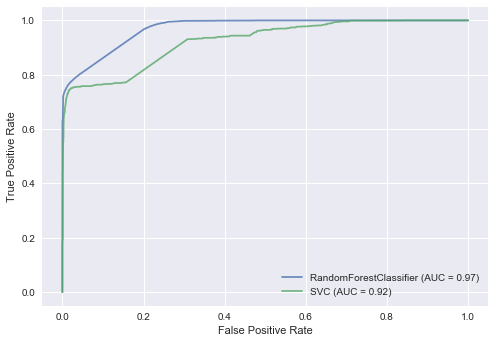

In [75]:

svc = SVC(random_state=42)
svc.fit(X, y)

ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, X, y, ax=ax, alpha=0.8)
# svc_disp = plot_roc_curve(svc, X, y)




svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

In [124]:
print('Score: ', rfc.score(X_train, y_train))


Score:  0.9311


# beginning EDA make sure to dummyize subs

In [150]:
from collections import Counter
results = Counter()
df_entertainment['Tokelems'].apply(results.update)
# print(results)
print(len(results))

# set(['someone', 'ft.jgt', 'my', 'is', 'to', 'going', 'place', 'nickname'])

18029


In [639]:
# subs = Counter()
df['Subreddit'].unique()

array(['politics', 'libertarian', 'worldnews', 'offbeat', 'news',
       'truereddit', 'conspiracy', 'conservative', 'frugal',
       'motorcycles', 'sex', 'drunk', 'food', 'lifehacks', 'guns',
       'progresspics', 'askscience', 'science', 'explainlikeimfive',
       'askhistorians', 'youshouldknow', 'todayilearned', 'space',
       'circlejerk', 'facepalm', 'jokes', 'adviceanimals', 'funny',
       'imgoingtohellforthis', 'movies', 'harrypotter', 'music', 'anime',
       'comicbooks', 'starwars', 'doctorwho', 'community', 'breakingbad',
       'thewalkingdead', 'startrek', 'mylittlepony', 'gameofthrones',
       'himym', 'tf2', 'dota2', 'leagueoflegends', 'minecraft', 'pokemon',
       'gaming', 'skyrim', 'starcraft'], dtype=object)

In [151]:
resies = results.most_common(20)
resies = dict(resies)
resies_mod = dict()
for k, v in resies.items():
    if v<50000:
        resies_mod[k] = v

In [434]:
(Counter(df['meta'].values))

Counter({'news': 408716,
         'lifestyle': 384494,
         'learning': 271179,
         'humor': 382197,
         'entertainment': 379414,
         'television': 321794,
         'gaming': 578206})

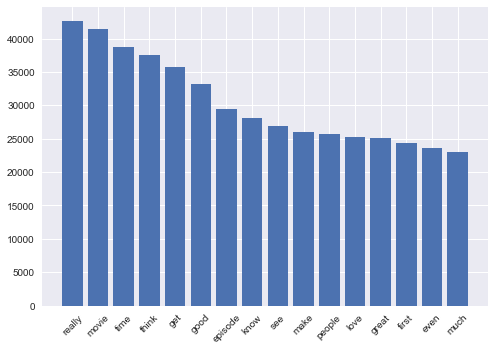

In [179]:

plt.bar(resies_mod.keys(), resies_mod.values())
plt.xticks(rotation=45)
plt.show()



In [73]:
from sklearn.feature_extraction import text
my_stop_words = list(text.ENGLISH_STOP_WORDS)
my_stop_words.append('www')
more_words_to_hate = ['http','things','thing', 'look', 'looking','lot','list','probably','just','year', 'https', 'well', 'time','like', 'maybe', 've', 'did','does', 'ca','does','got', 'times', 'would', 'need', 'actually', 'already', 'time', 'say', 'net', 'com', 'really', 
]
for i in more_words_to_hate:
    if i not in my_stop_words:
        my_stop_words.append(i)
        
        
new_stops = ['album','amazing', 'awesome', 'bad', 'best', 'better', 'bit', 'character', 'cool', 'day', 'end', 'episode', 'feel', 'film', 'going', 'good', 'great', 'know', 'life', 'little', 'll', 'looks', 'love', 'make', 'man', 'music', 'new', 'people', 'pretty', 'read', 'right', 'saw', 'scene', 'seen', 'sure', 'think', 'thought', 'want', 'wars', 'way', 'come', 'jpg','10','11','12', 'amp', 'days', 'edit', 'far', 'gets', 'fun', 'getting','let', 'later', 'makes', 'men', 'na','oh', 'op', 'post', 'reddit', 'said', 'remember', 'sorry', 'start', 'started', 'stop', 'tell', 'stuff', 'took', 'try','use', 'used', 'wait', 'wanted', 'week','went', 'yeah', 'yes', 'work', 'world']
        
for i in my_stop_words:
    new_stops.append(i)

In [82]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.965, min_df=.015, stop_words=new_stops)
tfidf_vectorizer.set_params(ngram_range =(1,2))
vectorized_y = tfidf_vectorizer.fit_transform(df_entertainment['Text'].values)

vectorized_y

<357672x46 sparse matrix of type '<class 'numpy.float64'>'
	with 348802 stored elements in Compressed Sparse Row format>

In [80]:
tfidf_vectorizer.fit(df_entertainment['Text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.965,
                max_features=None, min_df=0.015, ngram_range=(1, 1), norm='l2',
                preprocessor=None, smooth_idf=True,
                stop_words=['album', 'amazing', 'awesome', 'bad', 'best',
                            'better', 'bit', 'character', 'cool', 'day', 'end',
                            'episode', 'feel', 'film', 'going', 'good', 'great',
                            'know', 'life', 'little', 'll', 'looks', 'love',
                            'make', 'man', 'music', 'new', 'people', 'pretty',
                            'read', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=new_stops)

features = tfidf.fit_transform(df_entertainment['Text']).toarray()

labels = df_entertainment['Subreddit']
features.shape

In [67]:
# tfidf_vectorizer.get_feature_names()[vectorized_y[0].indices[1]]


In [83]:
tfidf_vectorizer.get_feature_names()

['anime',
 'big',
 'black',
 'book',
 'characters',
 'dark',
 'deadpool',
 'death',
 'definitely',
 'doing',
 'fan',
 'favorite',
 'force',
 'fuck',
 'fucking',
 'gt',
 'guess',
 'guy',
 'harry',
 'hope',
 'imgur',
 'interesting',
 'kanye',
 'kind',
 'long',
 'movie',
 'movies',
 'myanimelist',
 'nice',
 'old',
 'place',
 'point',
 'real',
 'second',
 'series',
 'shit',
 'song',
 'star',
 'story',
 'trying',
 'watch',
 'watched',
 'watching',
 'years',
 'youtube',
 'youtube watch']

In [ ]:
X = df_entertainment.drop

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

# NMF

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

vectorized = tfidf_vectorizer.fit_transform(clean_df2['Text'])

In [14]:
tfidf_vectorizer.get_feature_names()

['00',
 '000',
 '00000',
 '0000000031',
 '0000000642',
 '00000031',
 '00001',
 '00001001',
 '0000110',
 '00001g',
 '0001',
 '00026',
 '0004',
 '00063',
 '000bike',
 '000pull',
 '000sqft',
 '001',
 '00100000',
 '0011',
 '0015',
 '001c',
 '001jpg',
 '002',
 '003',
 '0033',
 '004',
 '005',
 '006225133476456637497',
 '007',
 '0079',
 '0080',
 '00800',
 '0088',
 '008jpg',
 '009',
 '00am',
 '00cst',
 '00gmt',
 '00pm',
 '00s',
 '01',
 '010',
 '01000001',
 '0103',
 '01100101',
 '01101000',
 '01101100',
 '01101111',
 '011915',
 '013',
 '014',
 '0140',
 '015',
 '016',
 '017',
 '01h29m41s',
 '01h41m51s',
 '01jpg',
 '01k',
 '02',
 '020',
 '021',
 '02102016',
 '0217',
 '0225',
 '0227',
 '023',
 '025',
 '028',
 '02933',
 '02937',
 '02fo',
 '02h13m39s',
 '02h26m08s',
 '03',
 '03231',
 '033',
 '0343',
 '036',
 '037',
 '038',
 '039',
 '03c12578',
 '03h10m20s',
 '03x0bu2w9hi',
 '04',
 '04042010',
 '042',
 '04e24f49b4d7b52aamp',
 '04e88fed000005dc',
 '04gif',
 '04jpg',
 '04mnf1ydnxi',
 '04putin',
 '05',


In [29]:
from sklearn.decomposition import NMF

model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(vectorized)
H = model.components_

def fit_nmf(r):
    nmf = NMF(n_components=r)
    nmf.fit(vectorized)
    W = nmf.transform(vectorized)
    H = nmf.components_
    return nmf.reconstruction_err_

In [28]:
vectorized

<2497636x49076 sparse matrix of type '<class 'numpy.float64'>'
	with 34722856 stored elements in Compressed Sparse Row format>

Text(0, 0.5, 'Reconstruction Errror')

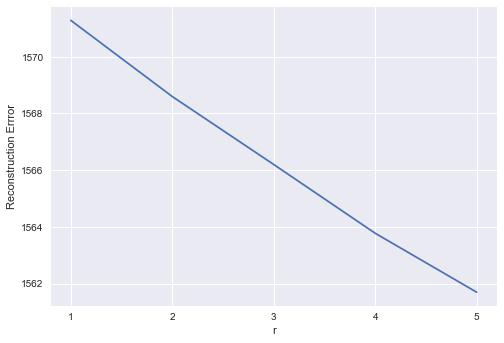

In [30]:
error = [fit_nmf(i) for i in range(1,6)]
plt.plot(range(1,6), error)
plt.xticks(range(1, 6))
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

# Random Forest 

In [46]:
clean_df = clean_df.dropna(axis=0)

In [97]:
df_select = clean_df.loc[clean_df['Subreddit'] == 'entertainment']
df_select

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
1306620,wait see whoop intergalact alien butt rogu who...,d02nuw8,movies,entertainment,1.455673e+09,cmonster1697,1.0,0.0,488.0,8426.0,0.0
1306621,amaz cinematograph best ever,d02q51i,movies,entertainment,1.455676e+09,BrodoFagginsIsMyName,1.0,0.0,1.0,457.0,0.0
1306622,final life chang,d02uuym,movies,entertainment,1.455684e+09,BrodoFagginsIsMyName,3.0,0.0,1.0,457.0,0.0
1306623,awesom thank,d02ftgc,movies,entertainment,1.455661e+09,JeopardyThis,3.0,0.0,1.0,-7.0,0.0
1306624,tom cruis charact john anderton kidnap pre-cog...,465qz3,movies,entertainment,1.455672e+09,tangowhiskey33,16.0,0.0,7346.0,6138.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1664682,love,d026lj4,harrypotter,entertainment,1.455648e+09,elbowsss,2.0,0.0,2212.0,8637.0,1.0
1664683,type ra hope manag get select current ras grea...,d02qfaf,harrypotter,entertainment,1.455677e+09,DEP61,2.0,0.0,5581.0,13488.0,0.0
1664684,bulletin board month p http iimgurcom7h3pfuyjpg,d02rem2,harrypotter,entertainment,1.455678e+09,laneebird,2.0,0.0,43.0,8.0,0.0
1664685,excel would pleas find first day great job,d02ecuj,harrypotter,entertainment,1.455659e+09,GoodniteMush,1.0,0.0,1.0,681.0,0.0


In [154]:
X = df_select.drop(['Subreddit', 'ID'], axis =1)
y = df_select['Subreddit']

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

In [152]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=s_stop, max_features =5000 )
vec_X_train = tfidf_vectorizer.fit_transform(X_train)
vec_X_test = tfidf_vectorizer.fit_transform(X_test)

In [153]:
# Train and fit model                                                   
rf = RandomForestClassifier(random_state=0,n_jobs=10, max_features = 'sqrt')

rf.fit(vec_X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(vec_X_test)
print('Accuracy score: {:.3}'.format(rf.score(vec_X_test, y_test)))

Accuracy score: 0.224


In [ ]:
full_class_names = ['entertainment_anime.csv', 'entertainment_comicbooks.csv', 'entertainment_harrypotter.csv', 'entertainment_movies.csv', 'entertainment_music.csv', 'entertainment_starwars.csv', 'gaming_dota2.csv','gaming_gaming.csv', 'gaming_leagueoflegends.csv','gaming_minecraft.csv','gaming_pokemon.csv','gaming_skyrim.csv','gaming_starcraft.csv', 'gaming_tf2.csv','humor_adviceanimals.csv', 'humor_circlejerk.csv', 'humor_facepalm.csv','humor_funny.csv','humor_imgoingtohellforthis.csv','humor_jokes.csv', 'learning_askhistorians.csv','learning_askscience.csv','learning_explainlikeimfive.csv', 'learning_science.csv', 'learning_space.csv', 'learning_todayilearned.csv', 'learning_youshouldknow.csv', 'lifestyle_drunk.csv', 'lifestyle_food.csv', 'lifestyle_frugal.csv', 'lifestyle_guns.csv','lifestyle_lifehacks.csv','lifestyle_motorcycles.csv','lifestyle_progresspics.csv', 'lifestyle_sex.csv','news_conservative.csv','news_conspiracy.csv', 'news_libertarian.csv', 'news_news.csv','news_offbeat.csv','news_politics.csv', 'news_truereddit.csv', 'news_worldnews.csv','television_breakingbad.csv','television_community.csv', 'television_doctorwho.csv', 'television_gameofthrones.csv', 'television_himym.csv', 'television_mylittlepony.csv','television_startrek.csv', 'television_thewalkingdead.csv']


In [135]:
enter_names = ['anime', 'comicbooks', 'harrypotter', 'movies', 'music', 'starwars']



KeyError: 'anime'

In [55]:
s_stop = set(stopwords.words())
print(len(s_stop))
new_stops = ['2015ref','publisherspage190ref','volume9', 'issue2','005', '1671', '2015', 'jpgthumbemerg', 'jpgthumbrightth', 'logo', 'page7','logo.png','2015.ref', 'nameleaf200kcit','ref', '005.jpgthumbrightth', 'whose', 'kind','png', 'jpg', 'wiktionaryzero', 'wiktionaryzero0', 'wiktionaryzero0', 'articlesquantum','0supsup', '0refcit', '1-3', 'redirectzero', '.', ',', 'nameleaf200k2cit', 'wiktionari', 'namecarb01cit','-', 'filezero', 'mvaramvarxmvari', 'page98','datemfyes1915228', 'year1989ref', '1671.jpgthumbemerg', 'refimprovedatemay','ligatureligatur', 'pppc1expiry2144', 'wiktionary','wiktionary0', 'n','improvedateoctob','baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'अक', 'अग', 'अझ', 'अन', 'अर', 'आजक', 'आत', 'आद', 'आफ', 'आय', 'ईक', 'उद', 'उनक', 'उनल', 'उह', 'एउट', 'एन', 'कog', 'कत', 'कम', 'कस', 'कसर', 'कह', 'गत', 'गय', 'गर', 'चम', 'छन', 'जत', 'जबक', 'जस', 'जसक', 'जसब', 'जसम', 'जसल', 'जह', 'तत', 'तथ', 'तदन', 'तप', 'तवम', 'नज', 'नत', 'नभन', 'नय', 'पक', 'पछ', 'पन', 'पय', 'पर', 'पष', 'पह', 'बन', 'बर', 'भएक', 'भय', 'भव', 'मल', 'यत', 'यथ', 'यद', 'यप', 'यसक', 'यसपछ', 'यसब', 'यसर', 'यह', 'रण', 'रत', 'रमश', 'रह', 'लस', 'वर', 'सक', 'सट', 'सध', 'सपछ', 'सब', 'सम', 'सर', 'सह', 'हन', 'हर', 'हरण', 'ἀλλ']
for i in new_stops:
    s_stop.add(i)
    
    
print(len(s_stop))




6255
6471


In [92]:
vectorizer = CountVectorizer(stop_words=s_stop)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
y_train_vec = vectorizer.transform(y_train)
rf = RandomForestClassifier(n_estimators=,
                           max_features='auto',
                           random_state=0,
                           oob_score=True)

rf.fit(X_train_vec, y_train)
rf.oob_score_
# print("Cross Val Score: ",cross_val_score(rf,X_train_vec,y_train,cv=5).mean())
# print("Train Score: ", round(rf.score(X_train_vec,y_train)))
# print("Train Score: ", round(rf.score(X_test_vec,y_test)))
# print("Dic Size:", len(vectorizer.get_feature_names()))

ValueError: Number of labels=1673416 does not match number of samples=10

In [111]:
X = df_select['Text']
y = df_select['meta']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

1306620    entertainment
1306621    entertainment
1306622    entertainment
1306623    entertainment
1306624    entertainment
               ...      
1664682    entertainment
1664683    entertainment
1664684    entertainment
1664685    entertainment
1664686    entertainment
Name: meta, Length: 356493, dtype: object

In [110]:

# train = pd.read_csv('../input/train.csv').fillna(' ')
# test = pd.read_csv('../input/test.csv').fillna(' ')


KeyError: 'Text'

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaimer : i think obama should nominate som...,d028c5d,politics,news,1.455651e+09,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way the process will be dragged out unt...,d026od6,politics,news,1.455648e+09,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republicans have always battled with severe ca...,d026wk3,politics,news,1.455649e+09,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,politics were so different back then. people o...,d02a3k3,politics,news,1.455653e+09,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,"equally ridiculous , here 's a 1970 law review...",d025wad,politics,news,1.455647e+09,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,for those with a woefully bad sense of directi...,d02c1s1,minecraft,gaming,1.455656e+09,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,the characters hand in first person is invisib...,464kj4,minecraft,gaming,1.455656e+09,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,i guess either the shaders use some feature th...,d02cxvk,minecraft,gaming,1.455657e+09,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,my guess is that you 're trying to use a brand...,d02ic1n,minecraft,gaming,1.455664e+09,nothingl_,1.0,0.0,104.0,807.0,0.0


# EDA and Exploratory Graphs

/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, "Histogram of users' link karma, removed outliers")

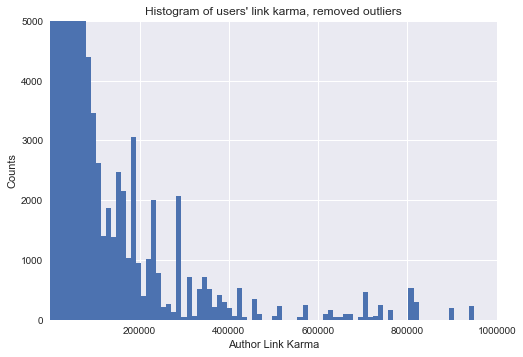

In [194]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 500)
plt.ylim(0, 5000)
plt.xlim(5,1000000)
ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, removed outliers")

Text(0.5, 1.0, "Histogram of users' link karma, yscale log")

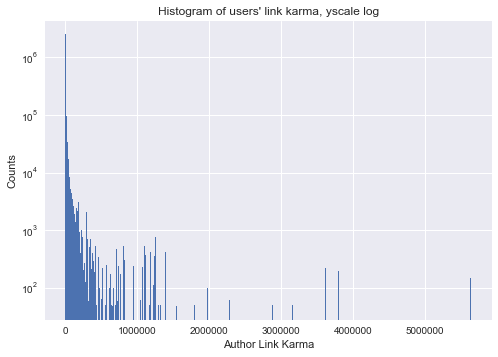

In [195]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 500)
# plt.ylim(0, 5000)
# plt.xlim(5,1000000)

ax.set_yscale('log')

ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, yscale log")

Text(0.5, 1.0, "Histogram of users' link karma, outliers removed yscale log")

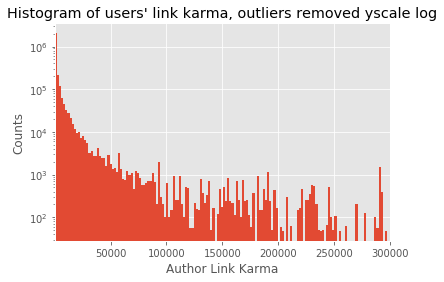

In [160]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 3000)
# plt.ylim()
plt.xlim(1,300000)

ax.set_yscale('log')

ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, outliers removed yscale log")

Text(0.5, 1.0, "Histogram of users' comment karma, removed outliers")

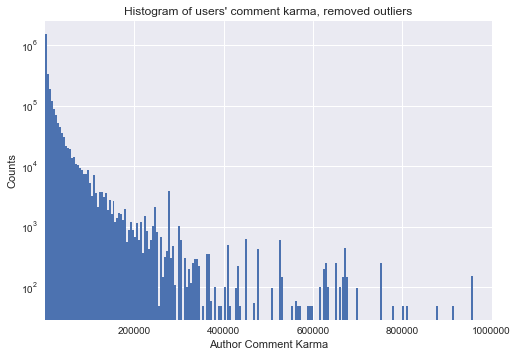

In [204]:
fig, ax = plt.subplots()
plt.hist(df.Author_Comment_Karma, bins = 500)
# plt.ylim(0, 5000)
plt.xlim(1,1000000)

ax.set_yscale('log')
ax.set_xlabel('Author Comment Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' comment karma, removed outliers")

(0, 1500000)

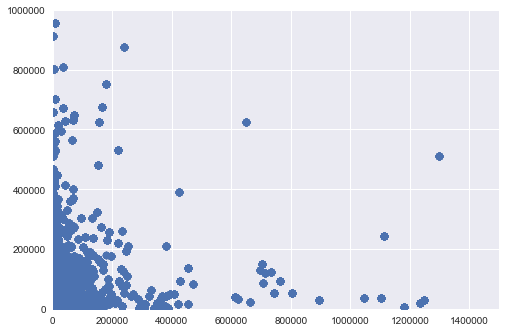

In [207]:
fig, ax = plt.subplots()

plt.scatter(df_test.Author_link_karma, df_test.Author_Comment_Karma)

# ax.set_yscale('')

ax.set_ylim(0, 1000000)
ax.set_xlim(0, 1500000)

Text(0.5, 1.0, 'Histogram of posts per hour of day')

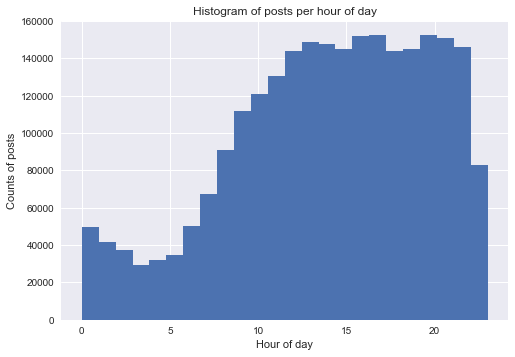

In [192]:
fig, ax = plt.subplots()

plt.hist(df_test.Time.dt.hour, bins = 24)
plt.style.use('seaborn')
ax.set_ylabel('Counts of posts')
ax.set_xlabel('Hour of day')
ax.set_title('Histogram of posts per hour of day')

In [1]:
df_test['Time'].dt.hour

NameError: name 'df_test' is not defined

In [205]:
df_test

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaim think obama nomin someon senat hold c...,d028c5d,politics,news,2016-02-16 13:25:06,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way process drag elect gop vote senat s...,d026od6,politics,news,2016-02-16 12:47:45,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republican alway battl sever case select amnesia,d026wk3,politics,news,2016-02-16 12:52:49,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,polit differ back peopl side least pretend rea...,d02a3k3,politics,news,2016-02-16 14:04:12,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,equal ridicul 1970 law review articl mcconnel ...,d025wad,politics,news,2016-02-16 12:30:13,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,woefulli bad sens direct use advic hand time p...,d02c1s1,minecraft,gaming,2016-02-16 14:46:51,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,charact hand first person invis look glitchi u...,464kj4,minecraft,gaming,2016-02-16 15:01:34,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,guess either shader use featur ad 18 glsl vers...,d02cxvk,minecraft,gaming,2016-02-16 15:06:52,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,guess tri use brand spank new graphic driver n...,d02ic1n,minecraft,gaming,2016-02-16 17:11:31,nothingl_,1.0,0.0,104.0,807.0,0.0


In [ ]:
import itertools

words = clean_df['Text'].str.lower().str.findall("\w+")
words = list(itertools.chain(words))
unique = set(words)
print(unique)

# PETER PREDICTIONS

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
group_names = ['Cities in USA', 'Biology', 'Articles abt Wikipedia', 'Music',
          'Cities in Japan', 'Pictures', 'Politics', 'TV & Movies',
          'Cities in USA', 'History']
with open('vectorizer.pk', 'rb') as fin:
    vectorizer = pickle.load(fin)
with open('sk_nmf.pk', 'rb') as fin:
    sk_nmf = pickle.load(fin)
print ("Please Enter Your Article:")
article = input()
my_dict = {"file_name": ["bozo.txt"], "contents": [article]}
new_df = pd.DataFrame.from_dict(my_dict)
X_new = vectorizer.transform(new_df['contents'])
W_new = sk_nmf.transform(X_new)
group_probs = W_new[0]
z = zip(group_names, group_probs)
z = sorted(z, key = lambda x: x[1], reverse=True)
for n, p in z:
    print (n + ":", p)